<font size=4>**name: Yonatan Juarez<br>github: yonatan-juarez-5**

<font size = 4>**(1a) Download the combined cycle power plant data**

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


<font size=5>(1bi) How many rows are in this data set? How many columsn?<br>
What do the rows and columns represent?

In [24]:
# file  = pd.ExcelFile("../data/CCPP/Folds5x2_pp.xlsx")
# df = file.parse(file.sheet_names[0])
df = pd.read_excel("../data/CCPP/Folds5x2_pp.xlsx", sheet_name="Sheet1")
# print(df.head)
num_rows = df.shape[0]
num_columns = df.shape[1]
print(f"rows: {num_rows}")
print(f"columns: {num_columns}")
print (f"{df.head()}")


rows: 9568
columns: 5
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


<font size=4><br>
- Columns represent ambient temperature (AT)<br>Exhaust vacuum (V)<br>Ambient pressure (AP)<br>
Relative humidity (RH)<br>Predicted net hourly electrical energy output (EP/PE)<br>Rows represent the data points for the features of the data set X=[AT, V, AP, RH, PE]

<font size=5>(1bii)Make pairwise scatterplots of all the variables in the dataset including predictors with the depedent variable<br>
Describe your findings 

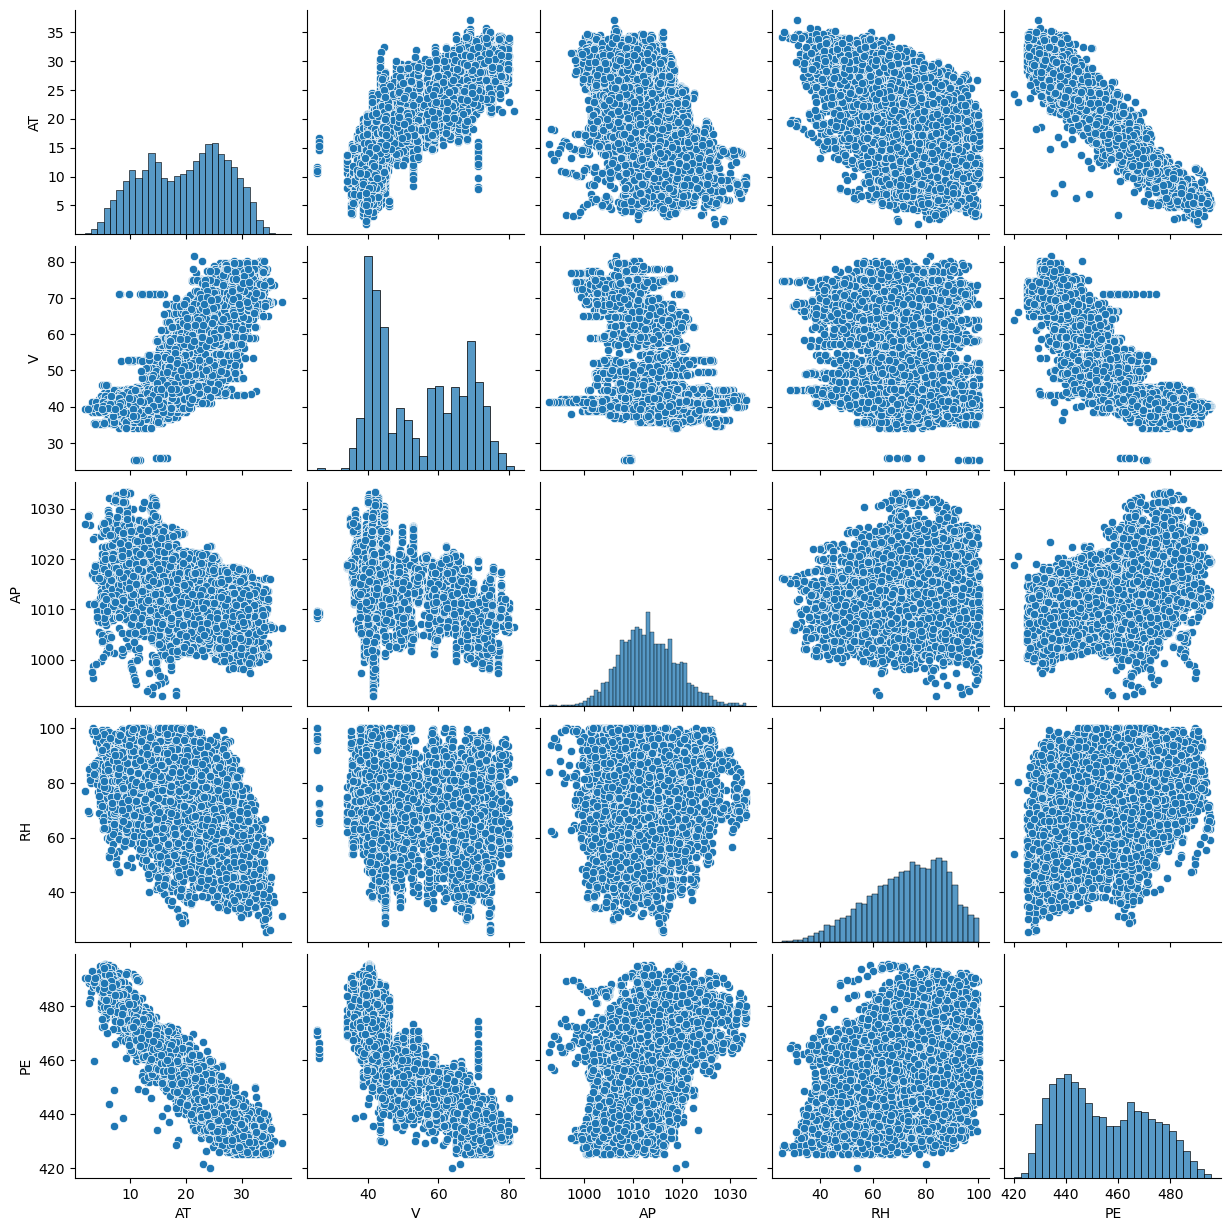

In [25]:
sns.pairplot(data=df)
plt.show()

In [26]:
print("Observations:")
print("- AT is negatively correlated with PE")
print("- AT is positively correlated with V")
print("- V is negatively correlated with PE")

Observations:
- AT is negatively correlated with PE
- AT is positively correlated with V
- V is negatively correlated with PE


<font size=5>(1biii) What are the mean, median, range, first and third quartiles and interquartile ranges for each of the variables in the data set?

In [27]:
stats = df.describe()

# print(f"\t\t\t\tStatistics:\n{stats.T}")

print("    Mean\t  Median\t  Range\t\t  Q1\t\t  Q3\t\t  IQR")
stats_df = {}
stats_list = []
for col,series in stats.items():
    q1 = series.loc['25%']
    q3 = series.loc['75%']
    iqr =  q3 - q1 
    range_ = series.loc['max'] - series.loc['min']
    med = df[col].median()
    mean = series.loc['mean']
    print(f"{col}: {mean:.3f}\t| {med:.3f}\t| {range_:.3f}\t| {q1:.3f}\t| {q3:.3f}\t| {iqr:.3f}")
    
#     stats_df = {"Variable": col,
#     "Mean": mean,
#     "Median": med,
#     "Range": range,
#     "First Quartile": q1,
#     "Third Quartile": q3,
#     "IQR": iqr
#     }
#     stats_list.append(stats_df)

# print(pd.DataFrame(stats_list))


    Mean	  Median	  Range		  Q1		  Q3		  IQR
AT: 19.651	| 20.345	| 35.300	| 13.510	| 25.720	| 12.210
V: 54.306	| 52.080	| 56.200	| 41.740	| 66.540	| 24.800
AP: 1013.259	| 1012.940	| 40.410	| 1009.100	| 1017.260	| 8.160
RH: 73.309	| 74.975	| 74.600	| 63.328	| 84.830	| 21.502
PE: 454.365	| 451.550	| 75.500	| 439.750	| 468.430	| 28.680


<font size=5>(1c) For each predictor, fit a simple linear regression model to predict the response.<br>


In [28]:
def linear_reg_model(predictor, y, x_int):
    pass

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:33   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -2.1713      0.007   -291.715      0.0

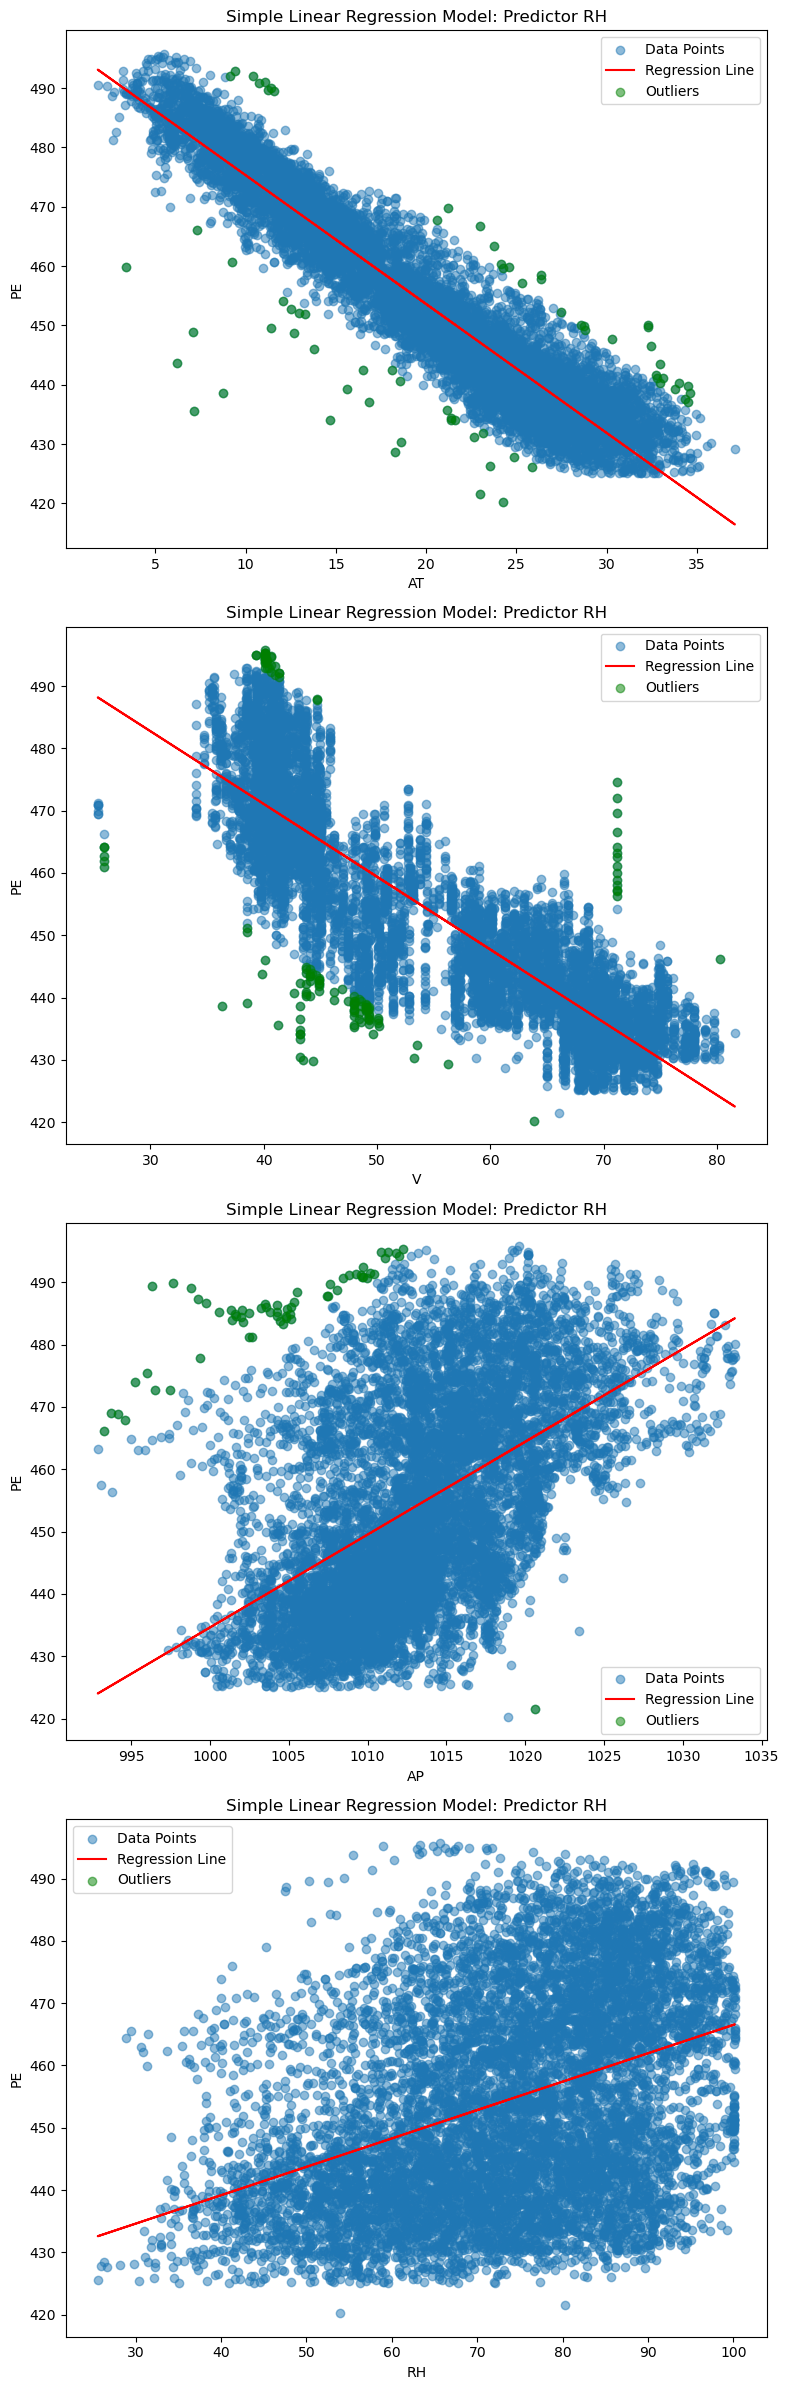

In [29]:
predictors = df.drop('PE', axis = 1)
pred_list :pd.DataFrame= []
cols = predictors.columns.size
for column in predictors.columns:
    pred_list.append(df[column])

y = df['PE']

outliers = []
# Create a figure and axis for plotting
fig, axs = plt.subplots(len(pred_list), figsize=(8, 6 * len(pred_list)))

i = 0
coefficients_dict = {}
for predictor in pred_list:
    x_int = sm.add_constant(predictor, prepend=False)
    model = sm.OLS(y, x_int).fit()

    print(model.summary())
    residuals = model.resid # residuals of model
    
    stats = residuals.describe()
    q1 = stats.loc['25%']
    q3 = stats.loc['75%']
    iqr = q3 - q1


    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outlier = residuals[(residuals < lower_bound) | (residuals > upper_bound)].index
    outliers.extend(outlier)

    coefficients_dict[predictor.name] = model.params
    print(model.params)

    # Create a DataFrame with predictor name and outlier y-values
    outlier_data = pd.DataFrame({predictor.name: predictor.iloc[outlier].tolist(), 'Y_Value': y.iloc[outlier].tolist()})
    if len(outlier) == 0:
        print(f"No outliers for {predictor.name}")
    else:
        print(f"No. of outliers for {predictor.name}: {len(outlier)}")
        print(outlier_data)

    axs[i].scatter(predictor, y, label="Data Points", alpha = 0.5)
    axs[i].plot(predictor, model.predict(x_int), color='red', label="Regression Line")
    axs[i].scatter(predictor.iloc[outlier], y.iloc[outlier], color='green', label="Outliers", alpha= 0.5)
    axs[i].set_title(f"Simple Linear Regression Model: Predictor {column}")
    axs[i].legend()
    axs[i].set_xlabel(predictor.name)
    axs[i].set_ylabel("PE")
    i += 1


# Show the plots
plt.tight_layout()
plt.show()

<font size=4><br>
- (AT) The AT predictor vs PE is concentrated around the best-fit line, with some outliers clearly evident from the data set<br>
- (V) The V predictor vs PE negatively correlated but data is a little more scattered when compared to the AT model<br>
- (AP) The AP predictor vs PE has residuals that lie above the best-fit line, including the outliers<br>
- (RH) The RH predictor vs PE data reports no outliers after using IQR to calculate them, which could be because the residuals are evenly spaced above/below the line

<font size=6>(1d) Fit a multiple regression model to predict the response using all of the predictors.<br>
Describe your results. For which predictors can we reject the null hypothesis H0 : Bj = 0?

In [30]:
predictors = df.drop('PE', axis = 1)
x_int = sm.add_constant(predictors, prepend=False)
y = df['PE']
model = sm.OLS(y, x_int).fit()
coefficients_multiple = model.params
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:33   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -1.9775      0.015   -129.342      0.0

<font size=5><br>
- We cannot reject the null hypothesis for any of the predictors since the p-value is 0<br>
for each predictor

<font size = 6>(1e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis and the multiple regression from 1d on the y-axis.

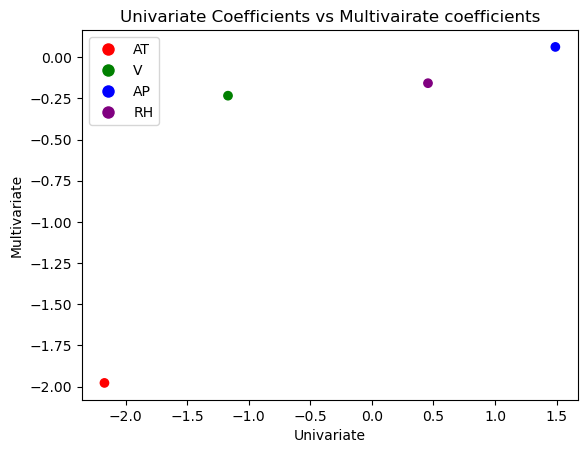

In [31]:
# x-axis = univariate regression coefficients
# y-axis = multiple regression coefficients

x_axis = []
y_axis = []
labels = []
# print(model.params)

i = 0
for key,val in coefficients_dict.items():
    x_axis.append(val[0])
    y_axis.append(coefficients_multiple[i])
    labels.append(key)
    i+= 1

colors = ['red', 'green', 'blue', 'purple']
plt.scatter(x_axis, y_axis, c= colors)
plt.xlabel("Univariate")
plt.ylabel("Multivariate")
plt.title("Univariate Coefficients vs Multivairate coefficients")

legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                            markersize=10, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=legend_labels, loc='best')
plt.show()



<font size = 6>(1f) Is there evidence of nonlinear association between any of the predictors

In [32]:
# y = B0 + B1x + B2x^2 + B3x^3 + e
degree = 3

for pred in predictors.columns:
    polynomial = PolynomialFeatures(degree)
    pred_train = polynomial.fit_transform(predictors[[pred]])
    model = sm.OLS(y, pred_train).fit()

    print(f"Nonlinear association for {pred}")
    print(model.summary())    


Nonlinear association for AT
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:34   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281  

<font size=4><br>
- For predictors AT, AP, and RH we can reject the null hypothesis because each other p-values are close<br>to 0,
so we can conclude that there is a nonlinear association between these predictors and the respone.<br><br>
- For predictor V, we cannot reject the null hypothesis because its p-value for X^2 and X^3 are not<br>negligible
, therefore we cannot deduce that there is a nonlinear association between V and the response.

<font size=6>(1g) Is there any evidence of association of interactions of predictors with the response?<br>
Run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant

In [33]:
X = predictors.copy()  # Make a copy of your predictor DataFrame
interaction_terms = pd.DataFrame()

terms = [['AT', 'V'], ["AT", "AP"], ["AT", "RH"], ["V", "AP"], ["V", "RH"], ["AP", "RH"]]

for term in terms:
    int_term = predictors[term[0]] * predictors[term[1]]
    interaction_terms[f"{term[0]}*{term[1]}"] = int_term

X = pd.concat([predictors, interaction_terms], axis=1)
x_int = sm.add_constant(X)
model = sm.OLS(y, x_int).fit()

print(model.summary())

# Perform hypothesis testing for each interaction term
for term in X:
    # Get the p-value for the coefficient of the interaction term
    p_value = model.pvalues[term]

    print(f"Interaction Term: {term}")
    print(f"\tP-Value: {p_value}")

    if p_value < 0.05:  # Adjust alpha as needed
        print(f"\tEvidence of association with the response\n")
    else:
        print(f"\tNo evidence of association with the response\n")


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:34   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

<font size=5><br>
- Using p < 0.05, interaction terms = {V, AP, RH, AT*V, AT*RH,V*AP, AP*RH} are statistically signficant<br>
- Interaction terms = {AT, AT*AP, V*RH} are statistically insignificant because their p-value
is greater than 0.05<br>
-  If we consider p < 0.10, AT, V*RH can be considered statistically significant since their p_value fall
below 0.10 along with the interaction terms that are below 0.05

<font size=6>(1h) Can you improve your model using possible interaction terms or nonlinear association between the<br>
predictors and the response?<br>Train the regression model on a randomly selected 70% subset of the data with the predictors..<br>
Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and<br>remove insignificant
variables using p-values.<br>
Test both models on the remaining pointd and report your train and test MSEs.

In [34]:
features = df.drop('PE', axis=1)
y = df['PE']
x_train, x_test, y_train, y_test = train_test_split(features, y, train_size=0.7, random_state=1, shuffle=True)
temp_df = pd.concat([x_train, y_train], axis=1)
print(temp_df.shape)
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(6697, 5)
(6697, 4) (2871, 4) (6697,) (2871,)


In [35]:
def train_model(type:str):
    x_int_train = sm.add_constant(x_train, prepend=False)
    model = sm.OLS(y_train, x_int_train).fit()
    y_train_pred = model.predict(x_int_train)
    
    x_int_test = sm.add_constant(x_test, prepend=False)
    y_test_pred = model.predict(x_int_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    res_dict = {"Features type": type,
                "Features used": "AT + V + AP + RH",
                    "train_mse": train_mse,
                    "test_mse": test_mse
                    }
    
    print(model.summary())
    return res_dict

In [36]:
all_predictors:pd.DataFrame = pd.DataFrame([train_model("all predictors")])
print(all_predictors.T)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.167e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:34   Log-Likelihood:                -19660.
No. Observations:                6697   AIC:                         3.933e+04
Df Residuals:                    6692   BIC:                         3.936e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -1.9714      0.018   -107.470      0.0

In [37]:
X = predictors.copy()  # Make a copy of your predictor DataFrame
interaction_terms = pd.DataFrame()
quad_terms = [["AT", "AT"], ["V", "V"],["AP", "AP"], ["RH", "RH"],['AT', 'V'], 
              ["AT", "AP"], ["AT", "RH"], ["V", "AP"], ["V", "RH"], ["AP", "RH"]]

for term in quad_terms:
    int_term = predictors[term[0]] * predictors[term[1]]
    interaction_terms[f"{term[0]}*{term[1]}"] = int_term

X = pd.concat([predictors, interaction_terms], axis=1)
# print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, shuffle=True)

x_int_train = sm.add_constant(x_train, prepend=False)
model = sm.OLS(y_train, x_int_train).fit()
y_train_pred = model.predict(x_int_train)

x_int_test = sm.add_constant(x_test, prepend=False)
y_test_pred = model.predict(x_int_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

res_dict = {
    "Features type": "Quadratic Nonlinearities",
    "Features used": "AT + V + AP + RH + AT*AT + V*V + AP*AP + RH*RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH",
    "train_mse": train_mse,
    "test_mse": test_mse
}

print(model.summary())
quad_df:pd.DataFrame = pd.DataFrame([res_dict])
print(quad_df.T)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7181.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:34   Log-Likelihood:                -19192.
No. Observations:                6697   AIC:                         3.841e+04
Df Residuals:                    6682   BIC:                         3.852e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -3.8103      3.684     -1.034      0.3

<font size= 5><br>
- Considering p < 0.05, we cannot reject the null hypothesis for predictors AT, V*V, AT*AP, V*AP,<br>V*RH,
therefore these features can be considered insignificant. However, we cannot remove<br>AT since we cannot remove basic
features from the original dataset.

In [38]:
X = predictors.copy()  # Make a copy of your predictor DataFrame
interaction_terms = pd.DataFrame()
significant_terms = [["AT", "AT"],["AP", "AP"], ["RH", "RH"],['AT', 'V'], 
             ["AT", "RH"], ["AP", "RH"]]

for term in significant_terms:
    int_term = predictors[term[0]] * predictors[term[1]]
    interaction_terms[f"{term[0]}*{term[1]}"] = int_term

X = pd.concat([predictors, interaction_terms], axis=1)
# print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1, shuffle=True)

x_int_train = sm.add_constant(x_train, prepend=False)
model = sm.OLS(y_train, x_int_train).fit()
y_train_pred = model.predict(x_int_train)

x_int_test = sm.add_constant(x_test, prepend=False)
y_test_pred = model.predict(x_int_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

res_dict = {
    "Features type": "Significant Nonlinearities",
    "Features used": "AT + V + AP + RH + AT*AT + AP*AP + RH*RH + AT*V + AT*RH + + AP*RH",
    "train_mse": train_mse,
    "test_mse": test_mse
}

print(model.summary())
sig_df:pd.DataFrame = pd.DataFrame([res_dict])
print(sig_df.T)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.004e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:17:34   Log-Likelihood:                -19198.
No. Observations:                6697   AIC:                         3.842e+04
Df Residuals:                    6686   BIC:                         3.849e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AT            -2.3804      0.101    -23.552      0.0

<font size=6>(1i) KNN Regression:<br><font size=5>(i.) Perform knn regression for this dataset using both normalized and
raw features.<br> Find the value of k = {1,2,..., 100} that gives you the bes fit.<br>
Plot the train and test errors in terms of 1/k

In [39]:
features = df.drop('PE', axis=1)
y = df['PE']
x_train, x_test, y_train, y_test = train_test_split(features, y, train_size=0.7, random_state=1, shuffle=True)
temp_df = pd.concat([x_train, y_train], axis=1)
print(temp_df.shape)
# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6697, 5)
(6697, 4) (2871, 4) (6697,) (2871,)


In [40]:

def runKnn(type:str):
    train_errors = []
    test_errors = []
    inv_k = []

    best_k = 0
    best_test_err = float('inf')

    if type == "Normalized":
        scaler = MinMaxScaler()
        train_x_knn = scaler.fit_transform(x_train)
        test_x_knn = scaler.fit_transform(x_test)
    else:
        train_x_knn = x_train
        test_x_knn = x_test

    for k in range(1,101):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(train_x_knn, y_train)
        inv_k.append(1/k)

        train_pred = model.predict(train_x_knn)
        test_pred = model.predict(test_x_knn)

        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        train_errors.append(train_mse)
        test_errors.append(test_mse)

        if test_mse < best_test_err:
            best_k = k-1
            best_test_err = test_mse

    dict = {"Features": type,
                    "k": best_k,
                    "train_mse": train_errors[best_k],
                    "test_mse": test_errors[best_k]
                    }

    temp_df = pd.DataFrame([dict])
    print(temp_df.T)

    plt.plot(inv_k, train_errors, label="Train MSE")
    plt.plot(inv_k, test_errors, label="Test MSE")
    plt.xlabel("1/k")
    plt.ylabel("MSE")
    plt.title(f"{type} KNN")
    plt.legend()
    plt.show()

    return temp_df


                    0
Features   Normalized
k                   6
train_mse   11.011892
test_mse    14.910645


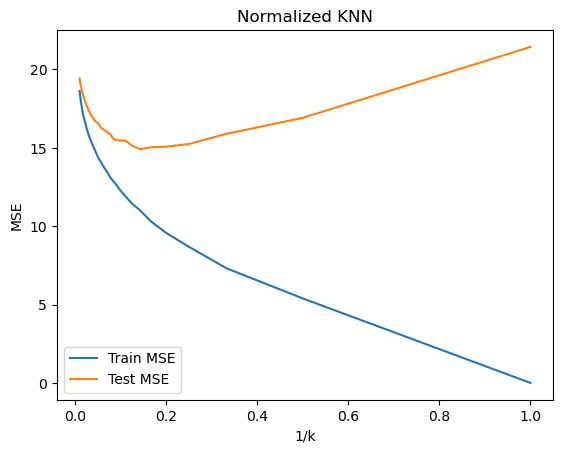

In [41]:
normalized_knn = runKnn("Normalized")

                   0
Features         Raw
k                  4
train_mse  10.552961
test_mse   15.704821


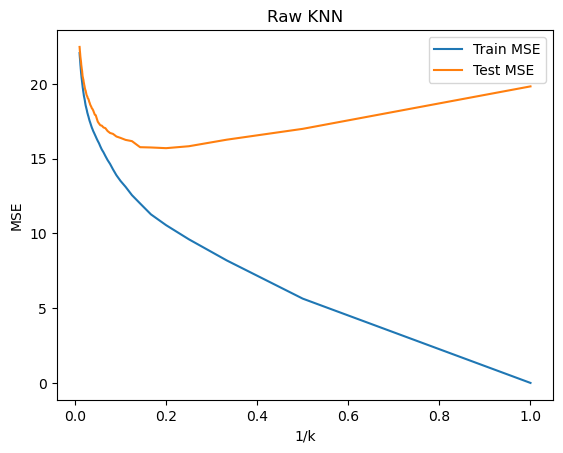

In [42]:
raw_knn = runKnn("Raw")


<font size =6>(1j) Compare the results of KNN Regression with the linear regression<br>model that has
the smallest test error.

In [43]:
all_pred = [all_predictors["train_mse"].round(3), all_predictors["test_mse"]]
quad_pred = [quad_df["train_mse"], quad_df["test_mse"]]
sig_pred = [sig_df["train_mse"], sig_df["test_mse"]]
kk_norm = [normalized_knn["train_mse"], normalized_knn["test_mse"]]
kk_raw = [raw_knn["train_mse"], raw_knn["test_mse"]]

types = ["All predictors", "Quad terms", "Significant terms", "Normalized KNN", "Raw KNN"]
train_mse_errors = [all_predictors["train_mse"].round(3).values[0], quad_df["train_mse"].round(3).values[0], 
              sig_df["train_mse"].round(3).values[0], normalized_knn["train_mse"].round(3).values[0], 
              raw_knn["train_mse"].round(3).values[0]]
test_mse_errors = [all_predictors["test_mse"].round(3).values[0], quad_df["test_mse"].round(3).values[0], 
              sig_df["test_mse"].round(3).values[0], normalized_knn["test_mse"].round(3).values[0], 
              raw_knn["test_mse"].round(3).values[0]]
errors = [all_pred, quad_pred, sig_pred, kk_norm, kk_raw]
errors_dict = {
    "Train_model": types,
    "Train MSE": train_mse_errors,
    "Test MSE": test_mse_errors
}
print(pd.DataFrame(errors_dict))

         Train_model  Train MSE  Test MSE
0     All predictors     20.766    20.777
1         Quad terms     18.060    18.217
2  Significant terms     18.093    18.264
3     Normalized KNN     11.012    14.911
4            Raw KNN     10.553    15.705


<font size=5><br>
- Based on analyzing the test errors, KNN regression performs better than linear regression.<br>
This could be attributed to the nonlinearity of the data set.

<font size=6>(2- ISLR: 2.4.1) For each of parts (a) through (d), indicate whether we would<br>generally expect the performance of a flexible statistical learning method<br>to be better or worse than an inflexible method. Justify your answer.

<font size=5>(a) The sample size n is extremely large, and the number of predictors p is small.<br>
- With large sample sizes, flexible models tend to perform better because they have more data<br>
to learn from and can catch intricate patterns.<br> Flexible models usually perform better with also large number of predictors, so when there is a small number of p, the flexible model may overfit.<br>For inflexible models, they may possibly underfit the data due to the large sample size. Inflexible models tend to be simple and not able to capture<br>
complex patterns. Inflexible models tend to perform better with a small p when there is a linear relationship between p and the response, and they are less prone to overfitting.
<br>In conclusion, the flexible model will perform better.

<font size=5>(b) The number of predictors p is extremely large, and the number of<br>observations n is small.<br>
- Considering p>>n, Flexible models can cappture complex patterns in the data and have the ability<br>
to fit the training data. However, they may also overfit since they are able to memorize<br>
the training data since there is a small number of observations.<br>
Since inflexible models are less prone to overfitting, they are ideal when you have a small number<br>
of observations. However, inflexible models may struggle with non-linear relationships <br>
when the data has a large number of predictors.
<br>In conclusion, the inflexible model will perform better for this case.

<font size=5>(c) The relationship between the predictors and response is highly non-linear.<br>
- Flexible models better at recognizing highly non-linear relations and are better suited<br>to
approximate complex patters. However, we must also consider the size of the data, interpretability of the model. For flexible models, interpretability can be a challenege when dealign with <br>highly
non-linear relationships.<br>
For inflexible models, since they are less prone to overfit, the results produced are more<br>
interpretable. Although, inflexible models can deal with simple non-linearity, in the case of<br>
highly non-linear, they may not fit the data as closely as a flexible model may.<br>
In conclusion, a flexible model will perform better for this case.

<font size =5>(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.<br>
- Flexible models are able to adapt when they encounter high variance in the error terms exist.<br>
Although flexible models can fit the training data closely, which includes the high variance errors,<br>the model may produce poor performance on new data.<br>
Inflexible models are focused on capturing a general trend, therefore high variance error terms<br>
have less of an impact on the performance. If the variance of the error terms dominate the data,<br>
the inflexible will not perform as well if there are non-linear relationships.<br>
In conclusion, a inflexible model will perform better with these conditions.

<font size=6>(3- ISLR: 2.4.7) The table below provides a training data set containing six observa- tions, three predictors, and one qualitative response variable.<br>
Obs. X1 X2 X3 Y<br>
 1     0  3  0  Red<br>
 2     2  0  0  Red<br>
 3     0  1  3  Red<br>
 4     0  1  2  Green<br>
 5    −1  0  1 Green<br>
 6     1  1  1 Red<br>
Suppose we wish to use this data set to make a prediction for Y when X1 = X2 = X3 = 0 using K-nearest neighbors.

<font size =5>(a) Compute the Euclidean distance between each observation and the test<br>point,X1 =X2 =X3 =0.

In [44]:
x_list = [[0,3,0], [2,0,0], [0,1,3], [0,1,2], [-1,0,1], [1,1,1,]]
test_point = [[0,0,0]]
cols = "Euclidean Distance with TP = [0,0,0]"
euclid_dist = euclidean_distances(x_list, test_point)
euclid_df = pd.DataFrame(euclid_dist.round(3), index=[1,2,3,4,5,6], columns=[cols])
print(euclid_df)

   Euclidean Distance with TP = [0,0,0]
1                                 3.000
2                                 2.000
3                                 3.162
4                                 2.236
5                                 1.414
6                                 1.732


<font size=5>(b) What is our prediction with K = 1? Why?
<font size = 4><br>
- For K = 1, I predict the output would be observation 5 since its euclidean distance is the<br>closest to the test point and
 k = 1, therefore the prediction would be green.

<font size=5>(c) What is our prediction with K = 3? Why?
<font size = 4><br>
- For K = 3, I predict the output would be observations 2, 5, and 6. Since 2 of the 3 neighbors are red,<br>
I predict it would be red.

<font size = 5>(d) If the Bayes decision boundary in this problem is highly non- linear, then<br>would we expect the best value for K to be large or small? Why?
<font size = 4><br>
- K is inversely proportional to the flexibility of the model. For large K, it means more linearity.<br>
In order to achieve high non-linearity, K will have to be small due to the inverse proportionality relationship.